In [1]:
import pandas as pd
import numpy as np

In [2]:
import seaborn as sns

In [3]:
import matplotlib.pyplot as plt

In [4]:
import collections
import random

In [5]:
import gc

In [6]:
from sklearn.metrics import auc

In [7]:
import utils

In [8]:
from sklearn.model_selection import KFold, GroupKFold, cross_val_score, train_test_split, ShuffleSplit, GroupShuffleSplit

In [9]:
from sklearn.metrics import plot_roc_curve

In [10]:
date_string = "20210720"

## Data Import

In [11]:
df_predictions = pd.read_csv(utils.get_base_path("heuristics/{}_smart_prediction.csv".format(date_string)), index_col=0)

/n/fs/grad/mmoeser/change/venv/lib64/python3.7/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [12]:
df_predictions.columns

Index(['true_change', 'optimal_change', 'optimal_change_with_fee',
       'address_type', 'power_of_ten_2', 'power_of_ten_3', 'power_of_ten_4',
       'power_of_ten_5', 'power_of_ten_6', 'power_of_ten_7', 'pow10',
       'fp_inout_count', 'fp_output_count', 'fp_zeroconf', 'fp_multisig',
       'fp_p2pkh', 'fp_absolute_fee', 'fp_relative_fee', 'two_hops',
       'fp_version', 'fp_locktime', 'fp_rbf', 'fp_segwit',
       'fp_possible_segwit', 'fp_ordered_inouts', 'fp_address_type', 'fp_p2sh',
       'fp_p2wsh', 'fp_p2wpkh'],
      dtype='object')

In [13]:
# drop two_hops, because it may be biased towards our ground truth set (due to higher rate of clustering)
df_predictions.drop(columns=["two_hops"], inplace=True)

In [14]:
true_outcome = df_predictions["true_change"].values

In [15]:
df_predictions.drop(columns=["true_change"], inplace=True)

In [16]:
df_predictions.drop(columns=["pow10"], inplace=True)

### Apply mask

In [17]:
mask_full = np.load(utils.get_base_path("evaluation/{}_mask.npy".format(date_string)))

In [18]:
len(mask_full)

70514856

In [19]:
vote_mask = [x for x, _ in utils.grouper(mask_full, 2)]

In [20]:
len(vote_mask) - np.sum(vote_mask)

858582

In [21]:
df_predictions = df_predictions[vote_mask]

In [22]:
true_outcome = true_outcome[vote_mask]

In [23]:
len(df_predictions), len(true_outcome)

(34398846, 34398846)

## Compute threshold vote on full dataset

In [24]:
df_predictions.head()

,optimal_change,optimal_change_with_fee,address_type,power_of_ten_2,power_of_ten_3,power_of_ten_4,power_of_ten_5,power_of_ten_6,power_of_ten_7,fp_inout_count,...,fp_version,fp_locktime,fp_rbf,fp_segwit,fp_possible_segwit,fp_ordered_inouts,fp_address_type,fp_p2sh,fp_p2wsh,fp_p2wpkh
36485,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,-1
38619,0,0,-1,-1,-1,-1,-1,-1,-1,0,...,-1,-1,-1,-1,-1,-1,0,-1,-1,-1
44447,1,1,-1,-1,-1,-1,-1,-1,0,1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,-1
46689,0,0,1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
47882,1,1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [25]:
df = df_predictions.copy()
vote = []
majority = []

for row in df.itertuples():
    vote_0 = sum([x == 0 for x in row[1:]])
    vote_1 = sum([x == 1 for x in row[1:]])
    if vote_0 == vote_1:
        vote.append(-1)
        majority.append(0)
    elif vote_0 > vote_1:
        vote.append(0)
        majority.append(vote_0 - vote_1)
    else:
        vote.append(1)
        majority.append(vote_1 - vote_0)

vote = np.array(vote)
majority = np.array(majority)

tprs = [0.0]
fprs = [0.0]
trs = [max(majority) + 1]
for threshold in reversed(range(1, max(majority) + 1)):
    # mask that tells us whether the change of an output can be determined
    has_outcome = (majority >= threshold)
    # number of correct outcomes among those that could be predicted
    correct = (true_outcome[has_outcome] == vote[has_outcome]).sum()
    # number of incorrect = predicted - correct
    incorrect = np.sum(has_outcome) - correct
    # correctly predicted out of all
    tpr = correct / len(vote)
    # incorrectly predicted out of all
    fpr = incorrect / len(vote)
    tprs.append(tpr)
    fprs.append(fpr)
    trs.append(threshold)
tprs.append(1)
fprs.append(1)
trs.append(0)

In [26]:
auc_score = auc(fprs, tprs)
print(auc_score)

0.9413449324108675


In [27]:
np.save("data/threshold-vote-full-tprs.npy", tprs)
np.save("data/threshold-vote-full-fprs.npy", fprs)
np.save("data/threshold-vote-full-trs.npy", trs)

In [28]:
for fpr, tpr, thr in zip(fprs, tprs, trs):
    print('%f' % round(fpr, 5), "\t", '%f' % round(tpr, 5), "\t", '%f' % round(thr, 5))

0.000000 	 0.000000 	 24.000000
0.000000 	 0.000000 	 23.000000
0.000000 	 0.000000 	 22.000000
0.000000 	 0.000010 	 21.000000
0.000000 	 0.000070 	 20.000000
0.000000 	 0.000400 	 19.000000
0.000000 	 0.001440 	 18.000000
0.000000 	 0.003920 	 17.000000
0.000000 	 0.008810 	 16.000000
0.000000 	 0.016900 	 15.000000
0.000000 	 0.028920 	 14.000000
0.000000 	 0.045920 	 13.000000
0.000000 	 0.070690 	 12.000000
0.000010 	 0.105120 	 11.000000
0.000030 	 0.152030 	 10.000000
0.000080 	 0.213140 	 9.000000
0.000250 	 0.288100 	 8.000000
0.000730 	 0.370470 	 7.000000
0.001750 	 0.459210 	 6.000000
0.003980 	 0.544610 	 5.000000
0.007460 	 0.636130 	 4.000000
0.016270 	 0.727200 	 3.000000
0.030630 	 0.825690 	 2.000000
0.060610 	 0.904310 	 1.000000
1.000000 	 1.000000 	 0.000000


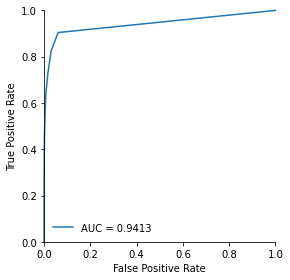

In [29]:
fig, ax = plt.subplots()

sns.lineplot(x=fprs, y=tprs, clip_on=False)
plt.axis("square")
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

legend_labels = ["AUC = {}".format(round(auc_score, 4))]

ax.legend(legend_labels, frameon=False)
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
sns.despine()
plt.tight_layout()

### Load cluster IDs

In [31]:
cluster_ids = np.load(utils.get_base_path("heuristics/{}-cluster-ids.npy".format(date_string)))

In [32]:
len(cluster_ids)

70514856

In [33]:
len(df_predictions)

34398846

In [34]:
cluster_id_txes = [x for x, _ in utils.grouper(cluster_ids, 2)]

In [35]:
cluster_id_txes = np.array(cluster_id_txes)[vote_mask]

In [37]:
assert len(df_predictions) == len(cluster_id_txes)

In [36]:
len(df_predictions), len(cluster_id_txes)

(34398846, 34398846)

In [38]:
del cluster_ids

In [39]:
ib_idx, oob_idx = next(GroupShuffleSplit(n_splits=1, test_size=.2, random_state=1337).split(X=df_predictions, groups=cluster_id_txes))

In [40]:
len(ib_idx), len(oob_idx)

(27768529, 6630317)

In [41]:
X_ib = df_predictions.iloc[ib_idx].copy()
y_ib = true_outcome[ib_idx]
X_oob  = df_predictions.iloc[oob_idx].copy()
y_oob  = true_outcome[oob_idx]

In [42]:
clusters_ib = cluster_id_txes[ib_idx]
clusters_oob = cluster_id_txes[oob_idx]

In [44]:
len(ib_idx) / len(oob_idx)

4.188114836741592

In [45]:
len(set(clusters_ib)) / len(set(clusters_oob))

3.999997159716256

In [46]:
collections.Counter(clusters_ib).most_common(10), collections.Counter(clusters_oob).most_common(10)

([(34508, 3424603),
  (159191, 374220),
  (23594133, 310348),
  (20988006, 197155),
  (23084303, 167784),
  (12503851, 137011),
  (40523343, 133746),
  (23425421, 131235),
  (105794406, 117648),
  (127814957, 115212)],
 [(61817017, 355389),
  (135574604, 232542),
  (109995066, 198323),
  (100100593, 107250),
  (91901708, 98331),
  (21357591, 75858),
  (102513996, 69140),
  (24516747, 65867),
  (10996631, 49453),
  (12200402, 49239)])

In [47]:
rf_clusters = ([(34508, 6849206),
  (159191, 748440),
  (23594133, 620696),
  (20988006, 394310),
  (23084303, 335568),
  (12503851, 274022),
  (40523343, 267492),
  (23425421, 262470),
  (105794406, 235296),
  (127814957, 230424)],
 [(61817017, 710778),
  (135574604, 465084),
  (109995066, 396646),
  (100100593, 214500),
  (91901708, 196662),
  (21357591, 151716),
  (102513996, 138280),
  (24516747, 131734),
  (10996631, 98906),
  (12200402, 98478)])

In [49]:
assert len(X_ib) == len(y_ib)
assert len(X_oob) == len(y_oob)
assert len(X_ib) + len(X_oob) == len(df_predictions)
assert len(set(X_ib.index).intersection(set(X_oob.index))) == 0

In [50]:
assert len(set(clusters_ib).intersection(set(clusters_oob))) == 0

### Apply to OOB set

In [51]:
df = X_oob.copy()
vote = []
majority = []

for row in df.itertuples():
    vote_0 = sum([x == 0 for x in row[1:]])
    vote_1 = sum([x == 1 for x in row[1:]])
    if vote_0 == vote_1:
        vote.append(-1)
        majority.append(0)
    elif vote_0 > vote_1:
        vote.append(0)
        majority.append(vote_0 - vote_1)
    else:
        vote.append(1)
        majority.append(vote_1 - vote_0)

vote = np.array(vote)
majority = np.array(majority)

tprs = [0.0]
fprs = [0.0]
trs = [2.0]
for threshold in reversed(range(1, max(majority) + 1)):
    # mask that tells us whether the change of an output can be determined
    has_outcome = (majority >= threshold)
    # number of correct outcomes among those that could be predicted
    correct = (y_oob[has_outcome] == vote[has_outcome]).sum()
    # number of incorrect = predicted - correct
    incorrect = np.sum(has_outcome) - correct
    # correctly predicted out of all
    tpr = correct / len(vote)
    # incorrectly predicted out of all
    fpr = incorrect / len(vote)
    tprs.append(tpr)
    fprs.append(fpr)
    trs.append(threshold)
tprs.append(1)
fprs.append(1)
trs.append(0)

In [52]:
auc_score = auc(fprs, tprs)

In [53]:
auc_score

0.9524305960856431

In [54]:
np.save("data/threshold-vote-oob-tprs.npy", tprs)
np.save("data/threshold-vote-oob-fprs.npy", fprs)
np.save("data/threshold-vote-oob-trs.npy", trs)

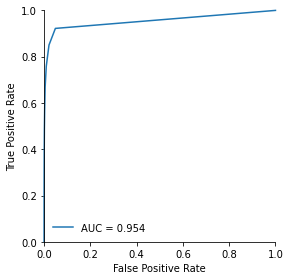

In [43]:
fig, ax = plt.subplots()

sns.lineplot(x=fprs, y=tprs, clip_on=False)
plt.axis("square")
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

legend_labels = ["AUC = {}".format(round(auc_score, 4))]

ax.legend(legend_labels, frameon=False)
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
sns.despine()
plt.tight_layout()
plt.savefig("majority-vote-testset.pdf")

In [44]:
for fpr, tpr, tr in zip(fprs, tprs, trs):
    print('%f' % round(fpr, 5), "\t", '%f' % round(tpr, 5), '\t', tr)

0.000000 	 0.000000 	 2.0
0.000000 	 0.000000 	 22
0.000000 	 0.000010 	 21
0.000000 	 0.000060 	 20
0.000000 	 0.000330 	 19
0.000000 	 0.001200 	 18
0.000000 	 0.003370 	 17
0.000000 	 0.007740 	 16
0.000000 	 0.015220 	 15
0.000000 	 0.027050 	 14
0.000000 	 0.044110 	 13
0.000000 	 0.069330 	 12
0.000010 	 0.104690 	 11
0.000030 	 0.153350 	 10
0.000090 	 0.218030 	 9
0.000260 	 0.298760 	 8
0.000610 	 0.390360 	 7
0.001300 	 0.483730 	 6
0.002570 	 0.573110 	 5
0.004610 	 0.668600 	 4
0.009500 	 0.758770 	 3
0.021260 	 0.850330 	 2
0.048860 	 0.922200 	 1
1.000000 	 1.000000 	 0


### Build combined plot

In [45]:
fpr_oob = np.load("oob-fpr.npy")
tpr_oob = np.load("oob-tpr.npy")
roc_auc_oob = np.load("oob-auc.npy")

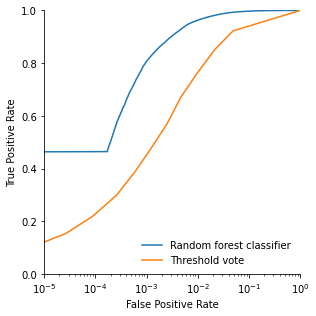

In [47]:
# Plot Out-of-bag manually
fig, ax = plt.subplots(figsize=(4.5,4.5))
ax.plot(fpr_oob,tpr_oob)
ax.plot(fprs, tprs)
ax.set_ylim(0, 1)
ax.set_xlim(0.00001, 1)
ax.set_xscale("log")
legend_label = ["Random forest classifier", "Threshold vote"]
ax.legend(legend_label, frameon=False)
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
sns.despine()
plt.tight_layout()
plt.savefig("rf-vote-comparison.pdf")